## Prereqs and Helper Functions

In [41]:
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [42]:
# Helps import code from Jupyter Notebook files. 
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [43]:
# This helps with Notebook Loader. 1. load the notebook document into memory. 2. create an empty Module. 
# 3. execute every cell in the Module namespace

class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [44]:
# This helps find simple object that tells you whether a name can be imported, and returns the appropriate loader. 
# All this one does is check, when you do:

class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [45]:
sys.meta_path.append(NotebookFinder())

In [46]:
#Review of overall data quality
def nullcounts(ser):
    return ser.isnull().sum()

def detail_describe(frame, func=['count', nullcounts, 'mean', 'std', 'min', 'median', 'max'],
                    numeric_only=False, **kwargs):
    return frame.agg(func, **kwargs)

## Import Data Prep 

In [51]:
## Importing the lab1 final data file

import lab1_final_data_v2_unscaled

## Verify Data

In [52]:
kick_data = lab1_final_data_v2_unscaled.kick_imputed

#should be categorical - Add Luxury, Axle, and Mileage
#we drop some of these later, but its good to be comprehensive for the raw data
categorical_features = ['Auction', 'Make', 'Model', 'Trim', 'SubModel',
                        'Color', 'Transmission', 'WheelType', 'Nationality', 
                        'Size', 'TopThreeAmericanName', 'BYRNO',
                        'VNST', 'Luxury', 'Axle', 'Mileage', 'Cylinder']

#should be floats
continuous_features = ['VehOdo', 'MMRAcquisitionAuctionAveragePrice',
                      'MMRAcquisitionRetailAveragePrice',
                      'VehBCost',
                      'WarrantyCost']

#should be int
ordinal_features = ['IsBadBuy', 'PurchDate', 'VehYear',
                    'VehicleAge', 'WheelTypeID',
                    'VNZIP1', 'IsOnlineSale']

kick_data[categorical_features] = kick_data[categorical_features].astype("category")

In [53]:
kick_data

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,Cylinder
0,0,1260144000,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1,Alloy,89046.0,OTHER ASIAN,MEDIUM,OTHER,8155.0,11636.0,21973,33619,FL,7100.0,0,1113.0,HIGH,0,Unknown,Unknown
1,0,1260144000,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1,Alloy,93593.0,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,10897.0,19638,33619,FL,7600.0,0,1053.0,HIGH,0,Unknown,Unknown
2,0,1260144000,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2,Covers,73807.0,AMERICAN,MEDIUM,CHRYSLER,3202.0,6943.0,19638,33619,FL,4900.0,0,1389.0,HIGH,0,Unknown,Unknown
3,0,1260144000,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1,Alloy,65617.0,AMERICAN,COMPACT,CHRYSLER,1893.0,4658.0,19638,33619,FL,4100.0,0,630.0,GOOD,0,Unknown,Unknown
4,0,1260144000,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2,Covers,69367.0,AMERICAN,COMPACT,FORD,3913.0,7723.0,19638,33619,FL,4000.0,0,1020.0,HIGH,0,Unknown,Unknown
5,0,1260144000,ADESA,2004,5,MITSUBISHI,GALANT 4C,ES,4D SEDAN ES,WHITE,AUTO,2,Covers,81054.0,OTHER ASIAN,MEDIUM,OTHER,3901.0,6706.0,19638,33619,FL,5600.0,0,594.0,HIGH,0,Unknown,Unknown
6,0,1260144000,ADESA,2004,5,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,AUTO,2,Covers,65328.0,OTHER ASIAN,MEDIUM,OTHER,2966.0,6240.0,19638,33619,FL,4200.0,0,533.0,GOOD,0,Unknown,Unknown
7,0,1260144000,ADESA,2005,4,FORD,TAURUS,SE,4D SEDAN SE,WHITE,AUTO,2,Covers,65805.0,AMERICAN,MEDIUM,FORD,3313.0,6667.0,19638,33619,FL,4500.0,0,825.0,HIGH,0,Unknown,Unknown
8,0,1260144000,ADESA,2007,2,KIA,SPECTRA,EX,4D SEDAN EX,BLACK,AUTO,2,Covers,49921.0,OTHER ASIAN,MEDIUM,OTHER,6196.0,9687.0,21973,33619,FL,5600.0,0,482.0,HIGH,0,Unknown,Unknown
9,0,1260144000,ADESA,2007,2,FORD,FIVE HUNDRED,SEL,4D SEDAN SEL,RED,AUTO,1,Alloy,84872.0,AMERICAN,LARGE,FORD,7845.0,11734.0,21973,33619,FL,7700.0,0,1633.0,HIGH,0,Unknown,Unknown


In [54]:
detail_describe(kick_data)

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionRetailAveragePrice,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,Mileage,Luxury,Axle,Cylinder
count,72983.000000,7.298300e+04,72983.0,72983.000000,72983.000000,72983.0,72983.0,72983.0,72983.0,72983.0,72983.0,72983.000000,72983.0,72983.000000,72983.0,72983.0,72983.0,72983.000000,72983.000000,72983.0,72983.000000,72983.0,72983.000000,72983.000000,72983.000000,72983.0,72983.0,72983.0,72983.0
nullcounts,0.000000,0.000000e+00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
mean,0.122988,1.263092e+09,NaN,2005.343052,4.176644,NaN,NaN,NaN,NaN,NaN,NaN,1.472836,NaN,71499.995917,NaN,NaN,NaN,6128.909217,8497.034332,NaN,58043.059945,NaN,6729.249949,0.025280,1276.580985,NaN,NaN,NaN,NaN
std,0.328425,1.819602e+07,NaN,1.731252,1.712210,NaN,NaN,NaN,NaN,NaN,NaN,0.519704,NaN,14578.913128,NaN,NaN,NaN,2461.689142,3155.896033,NaN,26151.640415,NaN,1764.140211,0.156975,598.846788,NaN,NaN,NaN,NaN
min,0.000000,1.231114e+09,NaN,2001.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,4825.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,2764.000000,NaN,1.000000,0.000000,462.000000,NaN,NaN,NaN,NaN
median,0.000000,1.264032e+09,NaN,2005.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,73361.000000,NaN,NaN,NaN,6098.000000,8446.000000,NaN,73108.000000,NaN,6705.000000,0.000000,1155.000000,NaN,NaN,NaN,NaN
max,1.000000,1.293667e+09,NaN,2010.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN,115717.000000,NaN,NaN,NaN,35722.000000,39080.000000,NaN,99224.000000,NaN,45469.000000,1.000000,7498.000000,NaN,NaN,NaN,NaN


/Users/Dhyan/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/Dhyan/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


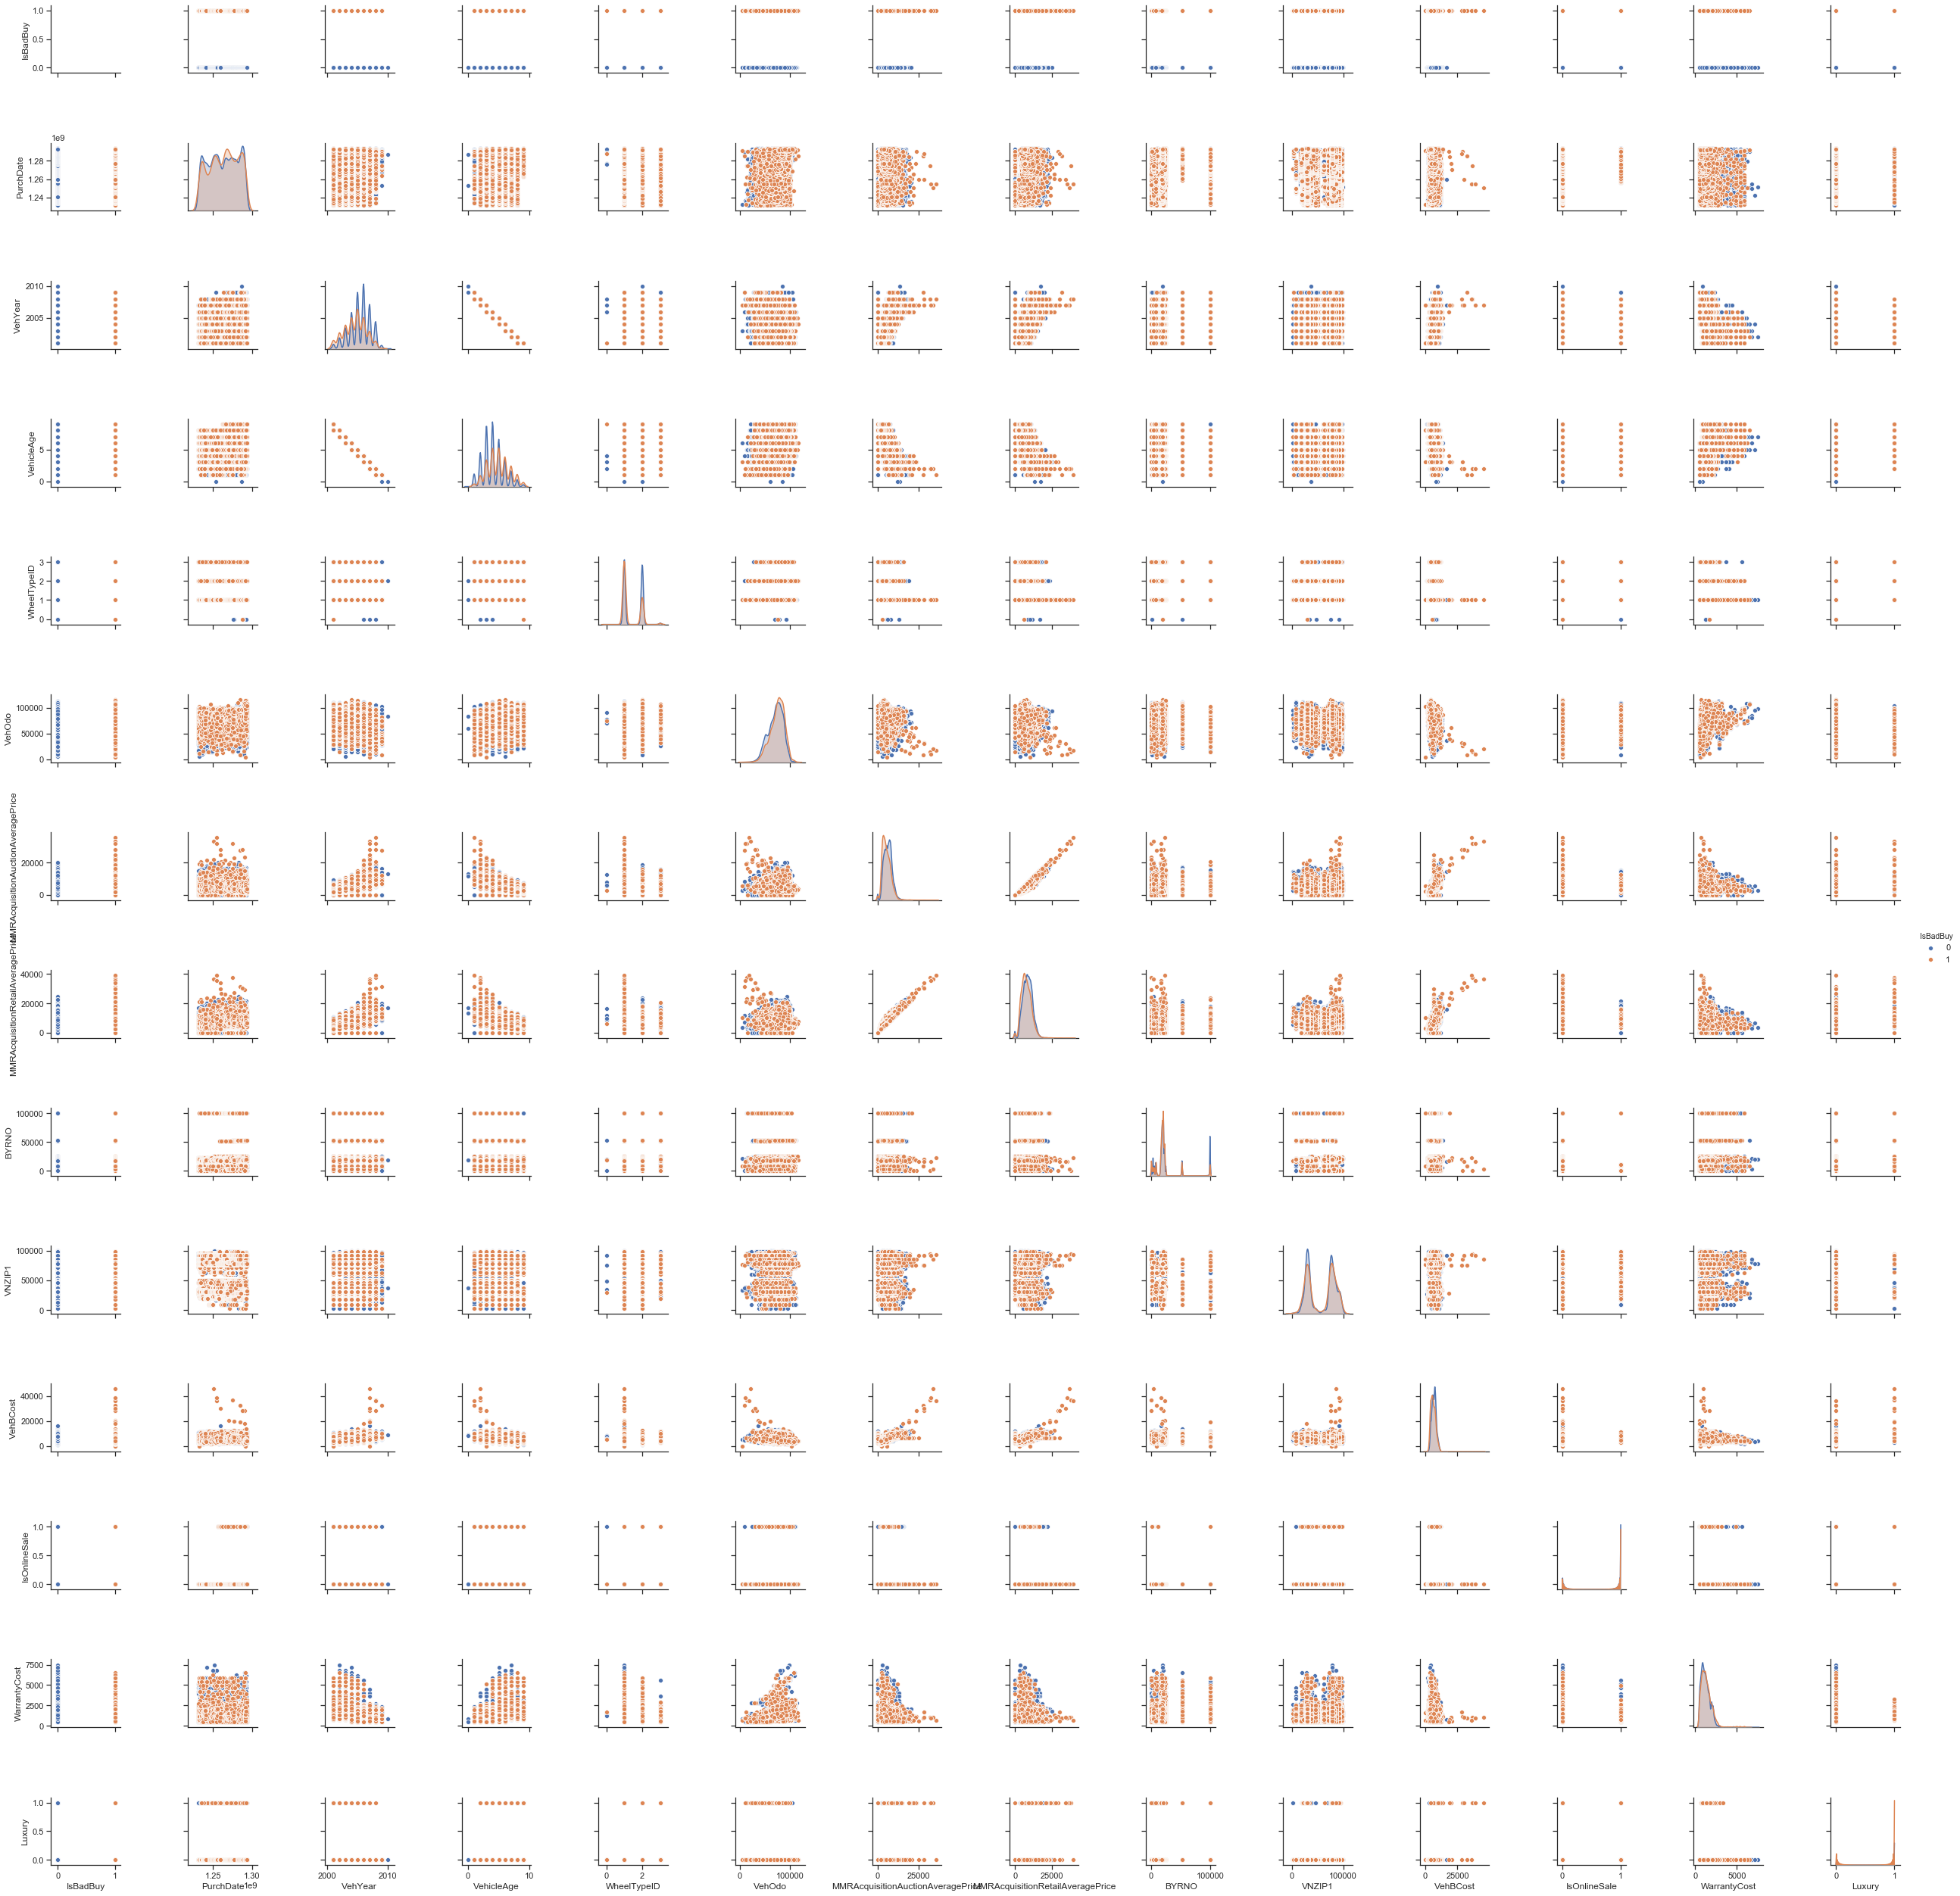

In [11]:
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")


sns.pairplot(kick_data, hue="IsBadBuy")

In [ ]:
import pandas as pd
import numpy as np
import h2o
import os
try:
    #clean slate, in case cluster was already running
    h2o.connect()
    h2o.cluster().shutdown(prompt=False)
except:
    print("Couldnt connect, no h2o found which is fine")

#h2o.init(max_mem_size = "12G")  #specify max number of bytes. uses all cores by default.
h2o.remove_all()  # incase the cluster was already running to clean slate

# Distributed Random Forest (H2O) - class: IsBadBuy classtype: categorical

In [68]:
h2o_frame = h2o.H2OFrame(kick_data)

#Set variables and columns
y = 'IsBadBuy'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = IsBadBuy
 
Predictors = ['Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder']


In [69]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15], seed=1234)
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
valid[y] = valid[y].asfactor()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)



In [70]:
from h2o.estimators.random_forest import H2ORandomForestEstimator

### The First Random Forest model with the following parameters

# **model_id:** It allows us to easily find our model in our interface  

# **ntrees:** Maximum number of trees used by the random forest. 
##### Default value is 50. 
##### We are using 200.

# **stopping_rounds:** Stopping criterion described above. 
#### It stops fitting new trees when 2-tree rolling average is within 0.001 (default) of the two prior rolling averages. 
#### It can be thought of as a convergence setting.

# **score_each_teration:** predict against training and validation for each tree. Default will skip several.

# **seed:** set the randomization seed so we can reproduce results


drf_IsBadBuy_v1 = H2ORandomForestEstimator(model_id="drf_IsBadBuy_v1", ntrees=200, stopping_rounds=2, 
                                           score_each_iteration=True, seed=100000, balance_classes = True)

drf_IsBadBuy_v1.train(x=x, y=y, training_frame=train, validation_frame = valid)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [71]:
# calling the model to get an overview of model statistics

drf_IsBadBuy_v1

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_IsBadBuy_v1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,25.0,25.0,2641319.0,20.0,20.0,20.0,4158.0,5279.0,4815.04




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07844764262902391
RMSE: 0.2800850632022777
LogLoss: 0.2572338738538334
Mean Per-Class Error: 0.018557349275371005
AUC: 0.9966960542649986
pr_auc: 0.7336392105702655
Gini: 0.9933921085299973

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1790116162843083: 


,,0,1,Error,Rate
0,0,43525.0,1221.0,0.0273,(1221.0/44746.0)
1,1,446.0,44319.0,0.01,(446.0/44765.0)
2,Total,43971.0,45540.0,0.0186,(1667.0/89511.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.179012,0.981540,299.0
1,max f2,0.154637,0.987893,307.0
2,max f0point5,0.250427,0.982005,276.0
3,max accuracy,0.195063,0.981444,294.0
4,max precision,0.633048,0.997074,135.0
5,max recall,0.038954,1.000000,363.0
6,max specificity,0.999998,0.998816,0.0
7,max absolute_mcc,0.195063,0.962927,294.0
8,max min_per_class_accuracy,0.210216,0.980333,290.0
9,max mean_per_class_accuracy,0.195063,0.981443,294.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 37.44 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.131649,1.000000,1.990582,1.990582,0.995502,1.000000,0.995502,1.000000,0.262057,0.262057,99.058222,99.058222
1,,2,0.150015,0.950346,1.995927,1.991237,0.998175,0.972627,0.995830,0.996649,0.036658,0.298716,99.592670,99.123655
2,,3,0.200009,0.835974,1.996448,1.992539,0.998436,0.892439,0.996481,0.970601,0.099810,0.398526,99.644773,99.253913
3,,4,0.300008,0.635489,1.996001,1.993693,0.998212,0.733033,0.997058,0.891415,0.199598,0.598124,99.600130,99.369314
4,,5,0.400007,0.451402,1.978353,1.989858,0.989387,0.544241,0.995140,0.804624,0.197833,0.795957,97.835339,98.985831
5,,6,0.500006,0.208977,1.843202,1.960528,0.921796,0.341750,0.980472,0.712051,0.184318,0.980275,84.320165,96.052763
6,,7,0.600004,0.059514,0.195914,1.666431,0.097978,0.105443,0.833392,0.610951,0.019591,0.999866,-80.408583,66.643087
7,,8,0.700003,0.031896,0.001340,1.428565,0.000670,0.043803,0.714434,0.529932,0.000134,1.000000,-99.865965,42.856459
8,,9,0.800058,0.016667,0.000000,1.249909,0.000000,0.023577,0.625087,0.466607,0.000000,1.000000,-100.000000,24.990924
9,,10,0.900012,0.002762,0.000000,1.111096,0.000000,0.010184,0.555666,0.415917,0.000000,1.000000,-100.000000,11.109594




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.09676879584485443
RMSE: 0.31107683270352104
LogLoss: 0.36011736302674385
Mean Per-Class Error: 0.3881556269437374
AUC: 0.5958789504558025
pr_auc: 0.3420735825144397
Gini: 0.19175790091160505

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16707239241852234: 


,,0,1,Error,Rate
0,0,9647.0,80.0,0.0082,(80.0/9727.0)
1,1,996.0,296.0,0.7709,(996.0/1292.0)
2,Total,10643.0,376.0,0.0976,(1076.0/11019.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.167072,0.354916,50.0
1,max f2,0.005851,0.399456,395.0
2,max f0point5,0.196773,0.537365,39.0
3,max accuracy,0.196773,0.903803,39.0
4,max precision,0.772208,1.000000,0.0
5,max recall,0.005851,1.000000,395.0
6,max specificity,0.772208,1.000000,0.0
7,max absolute_mcc,0.196773,0.400844,39.0
8,max min_per_class_accuracy,0.055805,0.550310,259.0
9,max mean_per_class_accuracy,0.149656,0.611844,63.0



Gains/Lift Table: Avg response rate: 11.73 %, avg score:  6.53 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.012705,0.361020,8.041287,8.041287,0.942857,0.459136,0.942857,0.459136,0.102167,0.102167,704.128704,704.128704
1,,2,0.021055,0.266438,6.952694,7.609604,0.815217,0.294531,0.892241,0.393861,0.058050,0.160217,595.269383,660.960353
2,,3,0.032308,0.174831,5.708685,6.947486,0.669355,0.208584,0.814607,0.329327,0.064241,0.224458,470.868496,594.748582
3,,4,0.040022,0.150130,1.404717,5.879152,0.164706,0.157238,0.689342,0.296158,0.010836,0.235294,40.471681,487.915166
4,,5,0.054088,0.132712,0.990422,4.607754,0.116129,0.136945,0.540268,0.254752,0.013932,0.249226,-0.957755,360.775396
5,,6,0.131137,0.099895,0.723277,2.325456,0.084806,0.108271,0.272664,0.168688,0.055728,0.304954,-27.672330,132.545556
6,,7,0.150014,0.092066,0.820061,2.136029,0.096154,0.096181,0.250454,0.159564,0.015480,0.320433,-17.993868,113.602906
7,,8,0.206734,0.086062,0.545833,1.699737,0.064000,0.086754,0.199298,0.139588,0.030960,0.351393,-45.416718,69.973729
8,,9,0.304837,0.073604,0.796848,1.409168,0.093432,0.076217,0.165228,0.119194,0.078173,0.429567,-20.315225,40.916760
9,,10,0.421000,0.062327,0.692952,1.211548,0.081250,0.064767,0.142056,0.104176,0.080495,0.510062,-30.704818,21.154824




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-10-21 13:46:34,0.019 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-21 13:46:35,1.367 sec,1.0,0.336804,1.837794,0.927055,0.240406,1.767477,0.105298,0.719606,17.876883,0.551879,0.045278,1.166441,0.517833
2,,2019-10-21 13:46:36,1.950 sec,2.0,0.329068,1.510888,0.936575,0.285584,1.801025,0.095447,0.492318,6.595376,0.565362,0.101494,1.429448,0.654324
3,,2019-10-21 13:46:36,2.508 sec,3.0,0.323891,1.274005,0.944188,0.328350,1.825681,0.087605,0.388199,2.710589,0.563793,0.129917,1.808398,0.357020
4,,2019-10-21 13:46:37,2.981 sec,4.0,0.309931,1.095511,0.952553,0.351473,1.846516,0.075419,0.354960,1.548308,0.563801,0.140212,1.815217,0.463018
5,,2019-10-21 13:46:37,3.323 sec,5.0,0.299238,0.911006,0.960509,0.383398,1.869899,0.066765,0.325818,0.865194,0.573603,0.176151,2.396477,0.474272
6,,2019-10-21 13:46:38,3.600 sec,6.0,0.296722,0.757226,0.966727,0.439718,1.887909,0.060192,0.320427,0.714097,0.584496,0.212555,4.087458,0.155640
7,,2019-10-21 13:46:38,3.941 sec,7.0,0.295690,0.648279,0.971637,0.480613,1.904131,0.055717,0.316687,0.665294,0.596603,0.268885,4.791370,0.164988
8,,2019-10-21 13:46:38,4.297 sec,8.0,0.291466,0.552671,0.976672,0.513054,1.920530,0.050770,0.316024,0.587993,0.606568,0.286322,6.465897,0.183320
9,,2019-10-21 13:46:39,4.657 sec,9.0,0.288977,0.474507,0.980833,0.547829,1.935221,0.046109,0.315287,0.551469,0.623931,0.313089,7.341106,0.129776



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,WheelType,51798.503906,1.000000,0.164708
1,Model,50617.910156,0.977208,0.160954
2,VNST,35332.250000,0.682109,0.112349
3,Color,27774.832031,0.536209,0.088318
4,VehBCost,20338.785156,0.392652,0.064673
5,VehOdo,19647.996094,0.379316,0.062476
6,MMRAcquisitionAuctionAveragePrice,18945.105469,0.365746,0.060241
7,Make,16142.603516,0.311642,0.051330
8,VehicleAge,15207.107422,0.293582,0.048355
9,MMRAcquisitionRetailAveragePrice,14754.681641,0.284848,0.046917


In [72]:
# We will use scoring history function to view validation statistics.

#drf_IsBadBuy_v1.score_history()

In [73]:
# ### Distributed Random Forest #2
folds = 100
drf_IsBadBuy_v2 = H2ORandomForestEstimator(
    model_id="drf_IsBadBuy_v2",
    ntrees=200,
    max_depth=30,
    stopping_rounds=2,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000,
    nfolds = folds,
    keep_cross_validation_predictions = True,
    binomial_double_trees = True,
    balance_classes = True)


drf_IsBadBuy_v2.train(x=x, y=y, training_frame=train, validation_frame = valid)


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [70]:
drf_IsBadBuy_v2

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_IsBadBuy_v2


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,19.0,38.0,5225685.0,30.0,30.0,30.0,6218.0,6743.0,6488.7896




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.008759440396614419
RMSE: 0.09359188210851632
LogLoss: 0.08996819097464835
Mean Per-Class Error: 0.004034504040778875
AUC: 0.998441087189704
pr_auc: 0.14059531890377863
Gini: 0.9968821743794081

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30116712877117574: 


,,0,1,Error,Rate
0,0,44455.0,283.0,0.0063,(283.0/44738.0)
1,1,78.0,44665.0,0.0017,(78.0/44743.0)
2,Total,44533.0,44948.0,0.004,(361.0/89481.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,3.011671e-01,0.995975,264.0
1,max f2,2.283122e-01,0.997769,280.0
2,max f0point5,4.160461e-01,0.995180,235.0
3,max accuracy,3.011671e-01,0.995966,264.0
4,max precision,8.387424e-01,0.997049,80.0
5,max recall,1.237972e-01,1.000000,307.0
6,max specificity,1.000000e+00,0.997362,0.0
7,max absolute_mcc,3.011671e-01,0.991942,264.0
8,max min_per_class_accuracy,3.914065e-01,0.995150,242.0
9,max mean_per_class_accuracy,3.011671e-01,0.995965,264.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score: 49.77 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.430741,1.000000,1.993767,1.993767,0.996939,1.000000,0.996939,1.000000,0.858796,0.858796,99.376669,99.376669
1,,2,0.500006,0.388685,1.966659,1.990012,0.983384,0.774678,0.995061,0.968786,0.136220,0.995017,96.665896,99.001151
2,,3,0.606959,0.044979,0.044920,1.647264,0.022461,0.088732,0.823678,0.813711,0.004804,0.999821,-95.507982,64.726351
3,,4,0.700079,0.023007,0.000000,1.428154,0.000000,0.030052,0.714117,0.709473,0.000000,0.999821,-100.000000,42.815419
4,,5,1.000000,0.000000,0.000596,1.000000,0.000298,0.003532,0.500028,0.497746,0.000179,1.000000,-99.940395,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.10189033637610721
RMSE: 0.3192026572196842
LogLoss: 0.42328281550823926
Mean Per-Class Error: 0.3862770189644795
AUC: 0.6142588963534206
pr_auc: 0.3436082032896325
Gini: 0.22851779270684114

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1115799736728774: 


,,0,1,Error,Rate
0,0,9584.0,143.0,0.0147,(143.0/9727.0)
1,1,997.0,295.0,0.7717,(997.0/1292.0)
2,Total,10581.0,438.0,0.1035,(1140.0/11019.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.111580,0.341040,94.0
1,max f2,0.008243,0.402827,392.0
2,max f0point5,0.137153,0.515176,75.0
3,max accuracy,0.142040,0.902169,73.0
4,max precision,0.545659,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.545659,1.000000,0.0
7,max absolute_mcc,0.142040,0.384272,73.0
8,max min_per_class_accuracy,0.047499,0.555567,260.0
9,max mean_per_class_accuracy,0.085436,0.613723,137.0



Gains/Lift Table: Avg response rate: 11.73 %, avg score:  4.90 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010800,0.220325,7.955284,7.955284,0.932773,0.285820,0.932773,0.285820,0.085913,0.085913,695.528397,695.528397
1,,2,0.020056,0.169063,7.441655,7.718224,0.872549,0.187761,0.904977,0.240562,0.068885,0.154799,644.165453,671.822423
2,,3,0.033488,0.123801,4.552449,6.448482,0.533784,0.141806,0.756098,0.200953,0.061146,0.215944,355.244854,544.848222
3,,4,0.040022,0.110393,1.895253,5.705098,0.222222,0.114323,0.668934,0.186809,0.012384,0.228328,89.525284,470.509783
4,,5,0.052092,0.098032,0.897751,4.591200,0.105263,0.102327,0.538328,0.167234,0.010836,0.239164,-10.224866,359.120047
5,,6,0.102369,0.079994,1.139204,2.895805,0.133574,0.086288,0.339539,0.127478,0.057276,0.296440,13.920432,189.580520
6,,7,0.151375,0.070702,0.852864,2.234421,0.100000,0.073890,0.261990,0.110130,0.041796,0.338235,-14.713622,123.442129
7,,8,0.207369,0.065985,0.594378,1.791574,0.069692,0.067194,0.210066,0.098536,0.033282,0.371517,-40.562168,79.157380
8,,9,0.307469,0.057097,0.719096,1.442417,0.084316,0.059867,0.169126,0.085947,0.071981,0.443498,-28.090361,44.241719
9,,10,0.408749,0.050319,0.779499,1.278160,0.091398,0.052684,0.149867,0.077705,0.078947,0.522446,-22.050085,27.815952




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09682173228658505
RMSE: 0.3111619068693741
LogLoss: 0.6856841004381841
Mean Per-Class Error: 0.33548791424877766
AUC: 0.7268233533027043
pr_auc: 0.39514715319109656
Gini: 0.4536467066054086

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.09068209421401484: 


,,0,1,Error,Rate
0,0,42769.0,1977.0,0.0442,(1977.0/44746.0)
1,1,4259.0,2064.0,0.6736,(4259.0/6323.0)
2,Total,47028.0,4041.0,0.1221,(6236.0/51069.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,9.068209e-02,0.398302,221.0
1,max f2,1.893837e-02,0.467392,350.0
2,max f0point5,2.322906e-01,0.539737,135.0
3,max accuracy,2.443061e-01,0.898197,130.0
4,max precision,6.684858e-01,0.923650,32.0
5,max recall,6.656524e-07,1.000000,399.0
6,max specificity,1.000000e+00,0.999553,0.0
7,max absolute_mcc,2.322906e-01,0.398920,135.0
8,max min_per_class_accuracy,2.471232e-02,0.653013,335.0
9,max mean_per_class_accuracy,4.069018e-02,0.664512,297.0



Gains/Lift Table: Avg response rate: 12.38 %, avg score:  4.41 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010006,0.682299,7.444477,7.444477,0.921722,0.872943,0.921722,0.872943,0.074490,0.074490,644.447677,644.447677
1,,2,0.020012,0.458927,7.096752,7.270614,0.878669,0.563286,0.900196,0.718115,0.071011,0.145501,609.675174,627.061425
2,,3,0.030038,0.297320,6.167952,6.902581,0.763672,0.376505,0.854628,0.604096,0.061838,0.207338,516.795176,590.258088
3,,4,0.040005,0.181470,3.824137,6.135607,0.473477,0.230716,0.759667,0.511071,0.038115,0.245453,282.413691,513.560683
4,,5,0.050011,0.135735,2.544715,5.417147,0.315068,0.154772,0.670713,0.439783,0.025463,0.270916,154.471499,441.714727
5,,6,0.100002,0.076099,1.698860,3.558368,0.210341,0.097902,0.440572,0.268876,0.084928,0.355844,69.886020,255.836777
6,,7,0.150013,0.055924,1.362983,2.826477,0.168755,0.065080,0.349954,0.200935,0.068164,0.424008,36.298335,182.647744
7,,8,0.200102,0.044965,1.215610,2.423248,0.150508,0.050013,0.300029,0.163157,0.060889,0.484896,21.561027,142.324834
8,,9,0.300006,0.031592,0.965658,1.937861,0.119561,0.037655,0.239932,0.121364,0.096473,0.581370,-3.434153,93.786073
9,,10,0.400008,0.023019,0.909361,1.680736,0.112591,0.027183,0.208097,0.097819,0.090938,0.672307,-9.063935,68.073571




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid,cv_21_valid,cv_22_valid,cv_23_valid,cv_24_valid,cv_25_valid,cv_26_valid,cv_27_valid,cv_28_valid,cv_29_valid,cv_30_valid,cv_31_valid,cv_32_valid,cv_33_valid,cv_34_valid,cv_35_valid,cv_36_valid,cv_37_valid,cv_38_valid,cv_39_valid,cv_40_valid,cv_41_valid,cv_42_valid,cv_43_valid,cv_44_valid,cv_45_valid,cv_46_valid,cv_47_valid,cv_48_valid,cv_49_valid,cv_50_valid,cv_51_valid,cv_52_valid,cv_53_valid,cv_54_valid,cv_55_valid,cv_56_valid,cv_57_valid,cv_58_valid,cv_59_valid,cv_60_valid,cv_61_valid,cv_62_valid,cv_63_valid,cv_64_valid,cv_65_valid,cv_66_valid,cv_67_valid,cv_68_valid,cv_69_valid,cv_70_valid,cv_71_valid,cv_72_valid,cv_73_valid,cv_74_valid,cv_75_valid,cv_76_valid,cv_77_valid,cv_78_valid,cv_79_valid,cv_80_valid,cv_81_valid,cv_82_valid,cv_83_valid,cv_84_valid,cv_85_valid,cv_86_valid,cv_87_valid,cv_88_valid,cv_89_valid,cv_90_valid,cv_91_valid,cv_92_valid,cv_93_valid,cv_94_valid,cv_95_valid,cv_96_valid,cv_97_valid,cv_98_valid,cv_99_valid,cv_100_valid
0,accuracy,0.8664056,0.052786868,0.8793774,0.8286853,0.90421456,0.86315787,0.8666667,0.8998035,0.8854369,0.86424476,0.89056605,0.8909091,0.8964803,0.88235295,0.8910506,0.87318087,0.84393066,0.5431862,0.9053255,0.8982036,0.8519924,0.9089253,0.82642996,0.92367905,0.91238093,0.88724583,0.8868687,0.9,0.8503788,0.88438135,0.913215,0.84540117,0.85341364,0.8876405,0.8956693,0.8912621,0.82306165,0.88645416,0.9038113,0.8809035,0.78498983,0.856,0.9099265,0.9134438,0.8742515,0.83739835,0.89271253,0.87090164,0.89271253,0.8992095,0.87992126,0.8834244,0.85119045,0.8333333,0.8392157,0.872093,0.83367556,0.8705441,0.8603239,0.65523463,0.8711434,0.8404453,0.9222904,0.78969955,0.8815261,0.9136546,0.9025735,0.8857678,0.81386864,0.9238095,0.8181818,0.90873015,0.906422,0.87759334,0.9048626,0.81362724,0.87362635,0.8961864,0.85119045,0.8562992,0.83744854,0.8777555,0.89668614,0.87356323,0.88659793,0.8625,0.808554,0.81616163,0.8548057,0.6919918,0.908,0.8946322,0.9010101,0.8342441,0.9017341,0.8828283,0.8962076,0.87647057,0.882243,0.85625,0.8460039,0.8729839
1,auc,0.72730494,0.03829588,0.773515,0.68997973,0.7684293,0.71353966,0.74649006,0.6784214,0.6890825,0.7387733,0.76641834,0.77768755,0.6835454,0.6871795,0.6845833,0.66315377,0.6460691,0.6660166,0.73723584,0.7534769,0.7381041,0.745868,0.6350169,0.73292696,0.7264931,0.7209044,0.72124964,0.80070204,0.76211977,0.7030519,0.7261641,0.7099604,0.7124334,0.74785984,0.7636497,0.7321115,0.764131,0.7291474,0.743806,0.722792,0.66125125,0.7371524,0.744144,0.75769377,0.7632358,0.7235074,0.80839163,0.68162465,0.69616187,0.78679407,0.65316194,0.6854906,0.7370308,0.6728364,0.6905095,0.7159151,0.7709982,0.66946906,0.669349,0.7130977,0.7566576,0.7075,0.7540002,0.72891766,0.77079606,0.7616771,0.70671594,0.74310464,0.7404753,0.794451,0.7912593,0.70843357,0.7019699,0.6701934,0.72082055,0.7375394,0.6971789,0.72235805,0.69138634,0.79402393,0.7212493,0.73738736,0.7051511,0.71335334,0.79801446,0.7036055,0.7518729,0.6954987,0.75494826,0.6838316,0.71044624,0.75534236,0.73309815,0.71390927,0.7531273,0.7804339,0.70936453,0.705735,0.7443948,0.7437071,0.78908414,0.7875732
2,err,0.1335944,0.052786868,0.12062257,0.17131475,0.09578544,0.1368421,0.13333334,0.100196466,0.11456311,0.13575526,0.109433964,0.10909091,0.10351967,0.11764706,0.108949415,0.12681913,0.15606937,0.4568138,0.09467456,0.1017964,0.14800759,0.09107468,0.17357002,0.07632094,0.08761905,0.11275416,0.113131315,0.1,0.14962122,0.11561866,0.08678501,0.15459883,0.14658634,0.11235955,0.10433071,0.10873786,0.17693837,0.11354582,0.09618875,0.11909651,0.21501014,0.144,0.090073526,0.08655617,0.1257485,0.16260162,0.10728745,0.12909836,0.10728745,0.100790516,0.12007874,0.11657559,0.14880952,0.16666667,0.16078432,0.12790698,0.16632444,0.12945591,0.13967611,0.34476534,0.12885663,0.15955473,0.07770961,0.21030


Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-10-18 13:26:03,15 min 54.546 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-18 13:26:04,15 min 55.587 sec,1.0,0.277355,2.459912,0.980179,0.031960,1.928163,0.020418,0.479767,7.749479,0.497896,0.113499,0.948760,0.882748
2,,2019-10-18 13:26:04,15 min 56.086 sec,2.0,0.260695,2.128825,0.981376,0.038646,1.931183,0.020577,0.351760,2.300284,0.602253,0.153346,1.128127,0.452763
3,,2019-10-18 13:26:05,15 min 56.446 sec,3.0,0.237247,1.714900,0.984035,0.044148,1.940682,0.018186,0.327448,1.514614,0.637742,0.213915,4.340017,0.312007
4,,2019-10-18 13:26:05,15 min 56.820 sec,4.0,0.215827,1.379118,0.985839,0.049754,1.946680,0.016467,0.322743,0.902225,0.611980,0.233735,5.079556,0.251656
5,,2019-10-18 13:26:06,15 min 57.186 sec,5.0,0.197294,1.116516,0.987456,0.055334,1.952240,0.014582,0.321182,0.766176,0.576065,0.248034,6.426509,0.172611
6,,2019-10-18 13:26:06,15 min 57.571 sec,6.0,0.180182,0.896457,0.989500,0.059914,1.959883,0.012747,0.320401,0.745748,0.580880,0.285039,7.260867,0.135675
7,,2019-10-18 13:26:06,15 min 57.945 sec,7.0,0.166077,0.716861,0.991151,0.067913,1.965771,0.011556,0.321657,0.678040,0.580154,0.277622,7.216540,0.126509
8,,2019-10-18 13:26:07,15 min 58.391 sec,8.0,0.152948,0.576010,0.992152,0.073988,1.969389,0.010609,0.319957,0.605685,0.585845,0.296669,7.521785,0.128596
9,,2019-10-18 13:26:07,15 min 58.815 sec,9.0,0.140655,0.456864,0.993440,0.080289,1.974392,0.009233,0.320711,0.578748,0.580722,0.285027,7.319854,0.129231



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Model,83933.171875,1.000000,0.153287
1,WheelType,77994.328125,0.929243,0.142441
2,VNST,58067.894531,0.691835,0.106049
3,Color,49582.457031,0.590737,0.090552
4,VehOdo,40604.121094,0.483767,0.074155
5,VehBCost,38947.070312,0.464025,0.071129
6,MMRAcquisitionAuctionAveragePrice,33995.300781,0.405028,0.062085
7,MMRAcquisitionRetailAveragePrice,29686.796875,0.353696,0.054217
8,Make,27641.964844,0.329333,0.050482
9,VehicleAge,25597.683594,0.304977,0.046749


In [61]:
# We will use scoring history function to view validation statistics.

#drf_IsBadBuy_v2.score_history()

In [75]:

## Final Prediction for Model 2
final_drf_predictions = drf_IsBadBuy_v2.predict(test)


drf prediction progress: |████████████████████████████████████████████████| 100%


In [76]:
final_drf_predictions

predict,p0,p1
0,0.934015,0.0659849
0,0.946506,0.0534939
0,0.981509,0.0184907
0,0.992212,0.00778847
0,0.972518,0.027482
0,0.958337,0.0416634
1,0.779675,0.220325
0,0.937655,0.0623454
0,0.945019,0.0549807
0,0.941783,0.0582169


In [77]:
# test set accuracy
(final_drf_predictions['predict']==test['IsBadBuy']).as_data_frame(use_pandas=True).mean()

predict    0.891785
dtype: float64

# AutoML - DRF: IsBadBuy (H2O)

In [73]:
h2o_frame = h2o.H2OFrame(kick_data)

#Set variables and columns
y = 'IsBadBuy'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = IsBadBuy
 
Predictors = ['Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder']


In [74]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
valid[y] = valid[y].asfactor()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [83]:
from h2o.automl import H2OAutoML

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml_IsBadBuy = H2OAutoML(max_models=20, seed=3000000, nfolds = 100, include_algos = ["DRF"], stopping_metric = "AUCPR")
aml_IsBadBuy.train(x=x, y=y, training_frame=train, validation_frame = valid)

# View the AutoML Leaderboard
lb = aml_IsBadBuy.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XRT_1_AutoML_20191018_151608,0.736025,0.317625,0.352802,0.294986,0.087017
XRT_1_AutoML_20191018_142738,0.734196,0.317989,0.363172,0.295229,0.08716
DRF_1_AutoML_20191018_151608,0.733916,0.3169,0.358642,0.295486,0.0873122
DRF_1_AutoML_20191018_142738,0.733481,0.318984,0.357036,0.295558,0.0873546
XRT_1_AutoML_20191018_142629,0.554775,0.913159,0.434435,0.593409,0.352135
DRF_1_AutoML_20191018_142629,0.521787,0.883234,0.499536,0.582385,0.339172
DRF_1_AutoML_20191018_142525,0.506076,1.09549,0.440477,0.650855,0.423612
XRT_1_AutoML_20191018_142525,0.504944,1.09704,0.499584,0.65156,0.42453


In [84]:
# The leader model is stored here
aml_IsBadBuy.leader

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_20191018_151608


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,47.0,47.0,3520119.0,20.0,20.0,20.0,3040.0,4002.0,3519.4893




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.08967219240214447
RMSE: 0.29945315560558794
LogLoss: 0.39176154172459166
Mean Per-Class Error: 0.34108553285734144
AUC: 0.7189315705312671
pr_auc: 0.3993299648291895
Gini: 0.4378631410625342

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3263195000608726: 


,,0,1,Error,Rate
0,0,43141.0,1788.0,0.0398,(1788.0/44929.0)
1,1,4286.0,1995.0,0.6824,(4286.0/6281.0)
2,Total,47427.0,3783.0,0.1186,(6074.0/51210.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.326320,0.396463,137.0
1,max f2,0.090823,0.457348,294.0
2,max f0point5,0.604292,0.549600,64.0
3,max accuracy,0.609971,0.900430,63.0
4,max precision,0.875000,0.939119,22.0
5,max recall,0.000032,1.000000,399.0
6,max specificity,1.000000,0.999644,0.0
7,max absolute_mcc,0.604292,0.409108,64.0
8,max min_per_class_accuracy,0.106680,0.648782,278.0
9,max mean_per_class_accuracy,0.149834,0.658914,241.0



Gains/Lift Table: Avg response rate: 12.27 %, avg score: 12.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010213,0.916667,7.576359,7.576359,0.929254,0.964036,0.929254,0.964036,0.077376,0.077376,657.635931,657.635931
1,,2,0.020250,0.823529,7.486949,7.532042,0.918288,0.868923,0.923819,0.916892,0.075147,0.152523,648.694878,653.204204
2,,3,0.030092,0.650000,6.325170,7.137322,0.775794,0.748156,0.875406,0.861705,0.062251,0.214775,532.517001,613.732205
3,,4,0.040012,0.487326,3.354351,6.199426,0.411417,0.556380,0.760371,0.786007,0.033275,0.248050,235.435139,519.942596
4,,5,0.050010,0.414400,2.452318,5.450297,0.300781,0.447753,0.668489,0.718383,0.024518,0.272568,145.231775,445.029694
5,,6,0.100430,0.272727,1.600950,3.517764,0.196359,0.328617,0.431460,0.522704,0.080720,0.353288,60.094976,251.776449
6,,7,0.150010,0.218365,1.156021,2.737178,0.141788,0.242869,0.335720,0.430215,0.057316,0.410603,15.602116,173.717788
7,,8,0.200449,0.181818,1.237336,2.359770,0.151762,0.198958,0.289430,0.372023,0.062410,0.473014,23.733598,135.977003
8,,9,0.300000,0.134433,1.023543,1.916362,0.125539,0.156372,0.235045,0.300462,0.101895,0.574908,2.354308,91.636151
9,,10,0.400000,0.101201,0.869288,1.654593,0.106620,0.117224,0.202939,0.254653,0.086929,0.661837,-13.071167,65.459322




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.3038921359855874
RMSE: 0.5512641254295325
LogLoss: 0.8054332157147608
Mean Per-Class Error: 0.4125725514567522
AUC: 0.5568942080593909
pr_auc: 0.2855213398509567
Gini: 0.11378841611878188

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.7234167583637433: 


,,0,1,Error,Rate
0,0,9201.0,406.0,0.0423,(406.0/9607.0)
1,1,1061.0,294.0,0.783,(1061.0/1355.0)
2,Total,10262.0,700.0,0.1338,(1467.0/10962.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.723417,0.286131,47.0
1,max f2,0.309840,0.414239,374.0
2,max f0point5,0.765960,0.394220,30.0
3,max accuracy,0.815603,0.887612,18.0
4,max precision,0.978723,1.000000,0.0
5,max recall,0.234043,1.000000,396.0
6,max specificity,0.978723,1.000000,0.0
7,max absolute_mcc,0.787238,0.282380,24.0
8,max min_per_class_accuracy,0.574904,0.505535,176.0
9,max mean_per_class_accuracy,0.708853,0.587427,54.0



Gains/Lift Table: Avg response rate: 12.36 %, avg score: 56.18 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011038,0.851064,7.488299,7.488299,0.925620,0.891126,0.925620,0.891126,0.082657,0.082657,648.829862,648.829862
1,,2,0.023901,0.787234,4.360587,5.805065,0.539007,0.806724,0.717557,0.845703,0.056089,0.138745,336.058727,480.506465
2,,3,0.033023,0.765957,2.669712,4.938945,0.330000,0.767607,0.610497,0.824130,0.024354,0.163100,166.971218,393.894518
3,,4,0.044882,0.744681,2.364780,4.258780,0.292308,0.745967,0.526423,0.803477,0.028044,0.191144,136.478002,325.877959
4,,5,0.050903,0.725338,1.348339,3.914534,0.166667,0.729490,0.483871,0.794726,0.008118,0.199262,34.833948,291.453398
5,,6,0.100347,0.682785,0.865724,2.412302,0.107011,0.705059,0.298182,0.750545,0.042804,0.242066,-13.427649,141.230191
6,,7,0.150064,0.660469,0.786738,1.873741,0.097248,0.675861,0.231611,0.725801,0.039114,0.281181,-21.326247,87.374107
7,,8,0.200055,0.646702,0.723379,1.586282,0.089416,0.658685,0.196078,0.709030,0.036162,0.317343,-27.662079,58.628175
8,,9,0.356596,0.617021,0.636454,1.169320,0.078671,0.627214,0.144538,0.673114,0.099631,0.416974,-36.354605,16.931974
9,,10,0.447181,0.595745,0.741383,1.082632,0.091641,0.597278,0.133823,0.657752,0.067159,0.484133,-25.861696,8.263244




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.08701702790791459
RMSE: 0.2949864876700534
LogLoss: 0.3176249233767935
Mean Per-Class Error: 0.33473838531610367
AUC: 0.7360250565550276
pr_auc: 0.43896637265106647
Gini: 0.4720501131100552

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2661317458045731: 


,,0,1,Error,Rate
0,0,42512.0,2417.0,0.0538,(2417.0/44929.0)
1,1,4094.0,2187.0,0.6518,(4094.0/6281.0)
2,Total,46606.0,4604.0,0.1271,(6511.0/51210.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.266132,0.401837,146.0
1,max f2,0.075272,0.469709,301.0
2,max f0point5,0.600063,0.555469,57.0
3,max accuracy,0.600063,0.901035,57.0
4,max precision,0.956807,0.955696,6.0
5,max recall,0.000229,1.000000,399.0
6,max specificity,0.999718,0.999933,0.0
7,max absolute_mcc,0.600063,0.414297,57.0
8,max min_per_class_accuracy,0.106701,0.658060,266.0
9,max mean_per_class_accuracy,0.150112,0.665262,224.0



Gains/Lift Table: Avg response rate: 12.27 %, avg score: 12.51 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.011072,0.900000,7.664258,7.664258,0.940035,0.935265,0.940035,0.935265,0.084859,0.084859,666.425829,666.425829
1,,2,0.020640,0.820000,7.487596,7.582362,0.918367,0.855054,0.929991,0.898081,0.071645,0.156504,648.759622,658.236197
2,,3,0.030092,0.650000,6.451778,7.227266,0.791322,0.743575,0.886437,0.849554,0.060978,0.217481,545.177770,622.726606
3,,4,0.040012,0.451413,3.530896,6.310841,0.433071,0.532728,0.774036,0.771004,0.035026,0.252508,253.089620,531.084054
4,,5,0.050010,0.375602,2.563787,5.561722,0.314453,0.406441,0.682155,0.698120,0.025633,0.278140,156.378674,456.172241
5,,6,0.100000,0.251385,1.707068,3.634772,0.209375,0.299502,0.445811,0.498850,0.085337,0.363477,70.706794,263.477153
6,,7,0.150010,0.201850,1.381676,2.883642,0.169465,0.224421,0.353684,0.407362,0.069097,0.432574,38.167574,188.364184
7,,8,0.200000,0.170372,1.121060,2.443082,0.137500,0.185283,0.299649,0.351853,0.056042,0.488616,12.105954,144.308231
8,,9,0.300000,0.129317,0.990288,1.958818,0.121461,0.148250,0.240253,0.283985,0.099029,0.587645,-0.971183,95.881760
9,,10,0.400000,0.101801,0.874065,1.687629,0.107206,0.114779,0.206991,0.241684,0.087406,0.675052,-12.593536,68.762936




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid,cv_11_valid,cv_12_valid,cv_13_valid,cv_14_valid,cv_15_valid,cv_16_valid,cv_17_valid,cv_18_valid,cv_19_valid,cv_20_valid,cv_21_valid,cv_22_valid,cv_23_valid,cv_24_valid,cv_25_valid,cv_26_valid,cv_27_valid,cv_28_valid,cv_29_valid,cv_30_valid,cv_31_valid,cv_32_valid,cv_33_valid,cv_34_valid,cv_35_valid,cv_36_valid,cv_37_valid,cv_38_valid,cv_39_valid,cv_40_valid,cv_41_valid,cv_42_valid,cv_43_valid,cv_44_valid,cv_45_valid,cv_46_valid,cv_47_valid,cv_48_valid,cv_49_valid,cv_50_valid,cv_51_valid,cv_52_valid,cv_53_valid,cv_54_valid,cv_55_valid,cv_56_valid,cv_57_valid,cv_58_valid,cv_59_valid,cv_60_valid,cv_61_valid,cv_62_valid,cv_63_valid,cv_64_valid,cv_65_valid,cv_66_valid,cv_67_valid,cv_68_valid,cv_69_valid,cv_70_valid,cv_71_valid,cv_72_valid,cv_73_valid,cv_74_valid,cv_75_valid,cv_76_valid,cv_77_valid,cv_78_valid,cv_79_valid,cv_80_valid,cv_81_valid,cv_82_valid,cv_83_valid,cv_84_valid,cv_85_valid,cv_86_valid,cv_87_valid,cv_88_valid,cv_89_valid,cv_90_valid,cv_91_valid,cv_92_valid,cv_93_valid,cv_94_valid,cv_95_valid,cv_96_valid,cv_97_valid,cv_98_valid,cv_99_valid,cv_100_valid
0,accuracy,0.87429976,0.04248194,0.84210527,0.8947368,0.8986355,0.8791423,0.8908382,0.9122807,0.89668614,0.86549705,0.8888889,0.88304096,0.8808594,0.9121094,0.8828125,0.8925781,0.90234375,0.90625,0.79296875,0.7636719,0.87890625,0.8300781,0.7714844,0.890625,0.8652344,0.7597656,0.8691406,0.89453125,0.8496094,0.875,0.83203125,0.8808594,0.9121094,0.9003906,0.890625,0.8496094,0.8769531,0.91015625,0.8671875,0.8769531,0.90625,0.7246094,0.85546875,0.9121094,0.84765625,0.91796875,0.8652344,0.8691406,0.9140625,0.9003906,0.86328125,0.87890625,0.8808594,0.8828125,0.78515625,0.90234375,0.8925781,0.875,0.93359375,0.91015625,0.9042969,0.9082031,0.8691406,0.8769531,0.9042969,0.90234375,0.890625,0.8613281,0.89453125,0.8144531,0.7734375,0.9160156,0.8828125,0.8730469,0.8808594,0.8574219,0.90625,0.9042969,0.8359375,0.8691406,0.9121094,0.90234375,0.90234375,0.89453125,0.8730469,0.8691406,0.87109375,0.87890625,0.86328125,0.7890625,0.89453125,0.91015625,0.87890625,0.8808594,0.86328125,0.9003906,0.87890625,0.7011719,0.91796875,0.9199219,0.9003906,0.91796875
1,auc,0.73609805,0.033036087,0.7752144,0.74409866,0.7475988,0.720194,0.7155856,0.69965047,0.74945056,0.74908096,0.73066753,0.751736,0.75912,0.7249961,0.75691247,0.73873466,0.73822063,0.78502166,0.7137993,0.68304515,0.731828,0.6799678,0.73219967,0.7376686,0.7298631,0.74040407,0.73488003,0.7809518,0.76833963,0.7764604,0.7474847,0.7344971,0.77570015,0.71602833,0.705392,0.6754899,0.7124791,0.7334597,0.79143006,0.66253227,0.7035015,0.6622439,0.7044932,0.7123964,0.6753946,0.7361846,0.7878289,0.7366004,0.7413035,0.7162724,0.75682455,0.71463865,0.707969,0.74614674,0.73219854,0.7595878,0.7603877,0.79559994,0.7691189,0.7085132,0.78980285,0.7397204,0.77909976,0.7262588,0.7494866,0.7471375,0.69682366,0.7859219,0.7839955,0.6964615,0.73039067,0.7365024,0.75554657,0.75181955,0.70437187,0.7487977,0.68868583,0.7150179,0.76555556,0.6538653,0.79070175,0.72267586,0.73545456,0.7358102,0.71763664,0.7838146,0.7855748,0.76387507,0.7059902,0.6992965,0.7816309,0.68151146,0.75076586,0.69228166,0.72130305,0.772172,0.7169449,0.69421273,0.751661,0.7810512,0.7543041,0.7484866
2,err,0.12570024,0.04248194,0.15789473,0.10526316,0.10136452,0.1208577,0.109161794,0.0877193,0.10331384,0.13450292,0.11111111,0.116959065,0.119140625,0.087890625,0.1171875,0.107421875,0.09765625,0.09375,0.20703125,0.23632812,0.12109375,0.16992188,0.22851562,0.109375,0.13476562,0.24023438,0.13085938,0.10546875,0.15039062,0.125,0.16796875,0.119140625,0.087890625,0.099609375,0.109375,0.15039062,0.123046875,0.08984375,0.1328125,0.123046875,0.09375,0.27539062,0.14453125,0.087890625,0.15234375,0.08203125,0.13476562,0.13085938,0.0859375,0.099609375,0.13671875,0.12109375,0.119140625,0.1171875,0.21484375,0.09765625,0.107421875,0.125,0.06640625,0.08984375,0.095703125,0.091796875,0.130859


Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-10-18 15:43:24,17 min 33.677 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-18 15:43:25,17 min 34.349 sec,5.0,0.358347,2.954537,0.625100,0.167974,3.813798,0.164070,0.604717,2.281945,0.533703,0.133296,2.178598,0.876391
2,,2019-10-18 15:43:26,17 min 34.945 sec,10.0,0.331748,1.725970,0.650625,0.230418,5.630672,0.139634,0.531082,0.797960,0.592782,0.221631,4.924370,0.228061
3,,2019-10-18 15:43:26,17 min 35.667 sec,15.0,0.318086,1.148671,0.671246,0.278525,6.847459,0.131942,0.584129,0.899324,0.581851,0.239953,6.766213,0.147692
4,,2019-10-18 15:43:27,17 min 36.361 sec,20.0,0.310977,0.828093,0.686634,0.316651,7.292777,0.130188,0.579398,0.877388,0.564650,0.259547,6.701448,0.130086
5,,2019-10-18 15:43:28,17 min 37.081 sec,25.0,0.306748,0.658398,0.695992,0.341646,7.447598,0.115993,0.556751,0.817898,0.574678,0.283812,6.979640,0.148695
6,,2019-10-18 15:43:29,17 min 37.867 sec,30.0,0.304284,0.555692,0.703897,0.362283,7.453864,0.127748,0.552597,0.808751,0.569739,0.280158,7.215438,0.135012
7,,2019-10-18 15:43:29,17 min 38.690 sec,35.0,0.301989,0.470954,0.710818,0.375682,7.549768,0.114919,0.545705,0.792806,0.567290,0.280491,7.473000,0.147145
8,,2019-10-18 15:43:30,17 min 39.486 sec,40.0,0.300942,0.428529,0.714021,0.388101,7.550397,0.120230,0.545747,0.792962,0.566770,0.279611,7.309419,0.121419
9,,2019-10-18 15:43:31,17 min 40.280 sec,45.0,0.299842,0.396587,0.716632,0.396570,7.607538,0.118590,0.557169,0.819874,0.553304,0.272671,7.205189,0.134738



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,WheelType,28807.597656,1.000000,0.207352
1,Model,18732.796875,0.650273,0.134835
2,VNST,14372.806641,0.498924,0.103453
3,Color,11397.916992,0.395657,0.082040
4,VehOdo,8827.924805,0.306444,0.063542
5,VehBCost,8806.508789,0.305701,0.063388
6,MMRAcquisitionAuctionAveragePrice,7626.932617,0.264754,0.054897
7,MMRAcquisitionRetailAveragePrice,7200.100098,0.249938,0.051825
8,Make,6766.556641,0.234888,0.048704
9,WarrantyCost,5220.951172,0.181235,0.037579


In [85]:
preds = aml_IsBadBuy.leader.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [86]:
contributions_IsBadBuy = aml_IsBadBuy.leader.predict_contributions(test)
names = contributions_IsBadBuy.names
names
len(names)

19

In [88]:
import shap
shap.initjs()
contributions_matrix = contributions_IsBadBuy.as_data_frame().values
shap_values = contributions_matrix[:,0:19]
expected_value = contributions_matrix[:,18].min()

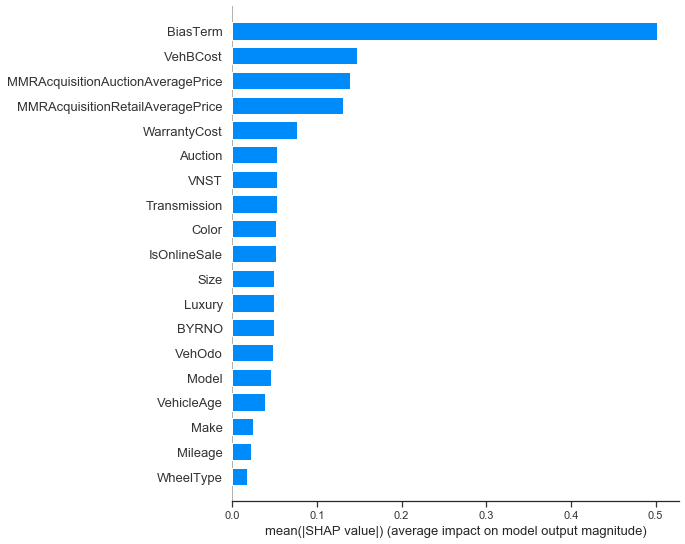

In [89]:
shap.summary_plot(shap_values, names, plot_type="bar")

# DRF - Task1- classification (Best of AutoML): IsBadBuy (h2o)

In [84]:
h2o_frame = h2o.H2OFrame(kick_data)

#Set variables and columns
y = 'IsBadBuy'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = IsBadBuy
 
Predictors = ['Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder']


In [85]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
valid[y] = valid[y].asfactor()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [86]:

########## DRF MODEL CODE #################

# ### Distributed Random Forest #2
folds = 10
drf_IsBadBuy_Final = H2ORandomForestEstimator(
    model_id="drf_IsBadBuy_Final",
    ntrees=47,
    max_depth=20,
    stopping_rounds=2,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000,
    nfolds = folds,
    keep_cross_validation_predictions = True,
    binomial_double_trees = True,
    stopping_metric = "AUCPR",
    balance_classes = True)


drf_IsBadBuy_Final.train(x=x, y=y, training_frame=train, validation_frame = valid)




drf Model Build progress: |███████████████████████████████████████████████| 100%


In [87]:
# calling the model to get an overview of model statistics

drf_IsBadBuy_Final

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_IsBadBuy_Final


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,20.0,40.0,4173405.0,20.0,20.0,20.0,4150.0,5268.0,4856.2




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.07774473331903829
RMSE: 0.2788274256938121
LogLoss: 0.26627289698411427
Mean Per-Class Error: 0.014480998442610415
AUC: 0.9968058280218162
pr_auc: 0.7098835439750082
Gini: 0.9936116560436323

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19618240570445145: 


,,0,1,Error,Rate
0,0,43978.0,801.0,0.0179,(801.0/44779.0)
1,1,496.0,44293.0,0.0111,(496.0/44789.0)
2,Total,44474.0,45094.0,0.0145,(1297.0/89568.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.196182,0.985570,293.0
1,max f2,0.157797,0.990380,304.0
2,max f0point5,0.224039,0.985648,285.0
3,max accuracy,0.196182,0.985519,293.0
4,max precision,0.534965,0.996132,170.0
5,max recall,0.000009,1.000000,399.0
6,max specificity,1.000000,0.998213,0.0
7,max absolute_mcc,0.196182,0.971061,293.0
8,max min_per_class_accuracy,0.211136,0.984524,289.0
9,max mean_per_class_accuracy,0.196182,0.985519,293.0



Gains/Lift Table: Avg response rate: 50.01 %, avg score: 37.33 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.143887,1.000000,1.987298,1.987298,0.993793,1.000000,0.993793,1.000000,0.285947,0.285947,98.729790,98.729790
1,,2,0.150005,0.965183,1.999710,1.987804,1.000000,0.978209,0.994046,0.999111,0.012234,0.298181,99.970979,98.780410
2,,3,0.200007,0.829051,1.994799,1.989553,0.997544,0.891152,0.994921,0.972122,0.099743,0.397924,99.479869,98.955275
3,,4,0.299999,0.629521,1.995691,1.991599,0.997990,0.726003,0.995944,0.890088,0.199554,0.597477,99.569117,99.159873
4,,5,0.400002,0.453502,1.985423,1.990055,0.992856,0.541667,0.995172,0.802980,0.198549,0.796026,98.542296,99.005475
5,,6,0.500006,0.210494,1.885415,1.969126,0.942844,0.349084,0.984706,0.712199,0.188548,0.984574,88.541515,96.912636
6,,7,0.599998,0.057248,0.150921,1.666115,0.075472,0.099887,0.833178,0.610155,0.015091,0.999665,-84.907851,66.611477
7,,8,0.700247,0.030609,0.001559,1.427813,0.000780,0.042078,0.714010,0.528827,0.000156,0.999821,-99.844121,42.781307
8,,9,0.800161,0.015543,0.000000,1.249526,0.000000,0.022597,0.624854,0.465616,0.000000,0.999821,-100.000000,24.952568
9,,10,1.000000,0.000000,0.000894,1.000000,0.000447,0.003426,0.500073,0.373252,0.000179,1.000000,-99.910632,0.000000




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.09919555045599526
RMSE: 0.31495325122309065
LogLoss: 0.38091738784146073
Mean Per-Class Error: 0.37148845789290075
AUC: 0.6682478936534801
pr_auc: 0.3918501205524311
Gini: 0.3364957873069603

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11431359315458753: 


,,0,1,Error,Rate
0,0,9503.0,74.0,0.0077,(74.0/9577.0)
1,1,978.0,312.0,0.7581,(978.0/1290.0)
2,Total,10481.0,386.0,0.0968,(1052.0/10867.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.114314,0.372315,90.0
1,max f2,0.025151,0.417163,333.0
2,max f0point5,0.133875,0.562174,81.0
3,max accuracy,0.150049,0.904850,71.0
4,max precision,0.718916,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.718916,1.000000,0.0
7,max absolute_mcc,0.150049,0.420750,71.0
8,max min_per_class_accuracy,0.042277,0.600775,258.0
9,max mean_per_class_accuracy,0.066619,0.628512,171.0



Gains/Lift Table: Avg response rate: 11.87 %, avg score:  4.75 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010030,0.319254,8.192177,8.192177,0.972477,0.423708,0.972477,0.423708,0.082171,0.082171,719.217694,719.217694
1,,2,0.021257,0.221295,7.595438,7.877016,0.901639,0.259903,0.935065,0.337196,0.085271,0.167442,659.543779,687.701601
2,,3,0.030459,0.145672,6.402264,7.431471,0.760000,0.178757,0.882175,0.289329,0.058915,0.226357,540.226357,643.147146
3,,4,0.040029,0.102020,2.106008,6.158257,0.250000,0.117299,0.731034,0.248200,0.020155,0.246512,110.600775,515.825715
4,,5,0.050152,0.089561,1.148732,5.147160,0.136364,0.094464,0.611009,0.217171,0.011628,0.258140,14.873150,414.716023
5,,6,0.100028,0.071609,1.290027,3.223916,0.153137,0.078391,0.382705,0.147972,0.064341,0.322481,29.002689,222.391619
6,,7,0.149995,0.063759,1.070457,2.506537,0.127072,0.067428,0.297546,0.121141,0.053488,0.375969,7.045698,150.653683
7,,8,0.200055,0.057657,0.960092,2.119570,0.113971,0.060580,0.251610,0.105987,0.048062,0.424031,-3.990823,111.956990
8,,9,0.299991,0.050166,0.861020,1.700311,0.102210,0.053716,0.201840,0.088574,0.086047,0.510078,-13.898026,70.031055
9,,10,0.400110,0.043142,0.727812,1.456962,0.086397,0.046573,0.172953,0.078064,0.072868,0.582946,-27.218850,45.696212




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09665782590559804
RMSE: 0.3108984173417389
LogLoss: 0.4477906001228018
Mean Per-Class Error: 0.3340811871619809
AUC: 0.7299510471308979
pr_auc: 0.4086370039517885
Gini: 0.45990209426179574

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10625970617767704: 


,,0,1,Error,Rate
0,0,42535.0,2247.0,0.0502,(2247.0/44782.0)
1,1,4279.0,2086.0,0.6723,(4279.0/6365.0)
2,Total,46814.0,4333.0,0.1276,(6526.0/51147.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.106260,0.389979,216.0
1,max f2,0.032319,0.470570,323.0
2,max f0point5,0.231129,0.525988,142.0
3,max accuracy,0.269225,0.896455,128.0
4,max precision,0.739344,0.956679,25.0
5,max recall,0.000005,1.000000,399.0
6,max specificity,1.000000,0.999821,0.0
7,max absolute_mcc,0.255783,0.386744,132.0
8,max min_per_class_accuracy,0.034809,0.658814,318.0
9,max mean_per_class_accuracy,0.046509,0.665919,295.0



Gains/Lift Table: Avg response rate: 12.44 %, avg score:  5.16 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,0.598688,7.486351,7.486351,0.931641,0.805540,0.931641,0.805540,0.074941,0.074941,648.635083,648.635083
1,,2,0.020001,0.443074,7.076416,7.281584,0.880626,0.522293,0.906158,0.664055,0.070699,0.145640,607.641625,628.158390
2,,3,0.030012,0.286549,5.807023,6.789743,0.722656,0.362471,0.844951,0.563461,0.058130,0.203771,480.702266,578.974328
3,,4,0.040002,0.197437,3.443856,5.954089,0.428571,0.236366,0.740958,0.481767,0.034407,0.238178,244.385591,495.408910
4,,5,0.050013,0.155873,2.511145,5.264962,0.312500,0.173185,0.655199,0.420003,0.025137,0.263315,151.114493,426.496189
5,,6,0.100006,0.094897,1.719010,3.492332,0.213923,0.118367,0.434604,0.269214,0.085939,0.349254,71.900981,249.233247
6,,7,0.149999,0.072982,1.385893,2.790277,0.172468,0.082581,0.347237,0.207011,0.069285,0.418539,38.589274,179.027741
7,,8,0.200012,0.059827,1.225140,2.398917,0.152463,0.065828,0.298534,0.171709,0.061273,0.479811,22.514030,139.891664
8,,9,0.299998,0.043439,1.092058,1.963354,0.135901,0.050918,0.244330,0.131450,0.109191,0.589002,9.205834,96.335398
9,,10,0.400004,0.032889,0.887615,1.694406,0.110459,0.037808,0.210861,0.108039,0.088767,0.677769,-11.238513,69.440606




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.86780465,0.015815688,0.8842229,0.88393724,0.8451817,0.8607893,0.8674699,0.8392188,0.8834332,0.86708736,0.8690639,0.87764204
1,auc,0.7302641,0.0100136725,0.7140877,0.7315458,0.7242415,0.7306922,0.7203648,0.7364849,0.7484331,0.7330433,0.73971534,0.7240325
2,err,0.13219537,0.015815688,0.11577708,0.116062775,0.15481833,0.13921069,0.13253012,0.16078122,0.11656679,0.13291264,0.1309361,0.12235796
3,err_count,675.7,76.61455,590.0,599.0,784.0,709.0,682.0,815.0,603.0,674.0,670.0,631.0
4,f0point5,0.4391227,0.043011528,0.50254095,0.46860573,0.38151965,0.41138095,0.43486664,0.3677531,0.48812664,0.44117647,0.44975537,0.44550174
5,f1,0.39720416,0.01591968,0.37632135,0.4039801,0.37678856,0.39036974,0.3975265,0.38490567,0.42406878,0.40669015,0.4163763,0.39501438
6,f2,0.36636913,0.027205212,0.3007773,0.35501924,0.37217337,0.37140054,0.36609176,0.40373653,0.37487334,0.37720445,0.38760948,0.35480538
7,lift_top_group,7.536625,0.36618012,6.9042134,7.7437778,6.959868,7.5965323,7.255945,7.8437138,7.8021827,7.588999,7.79887,7.8721485
8,logloss,0.44776094,0.020126062,0.45950836,0.4616094,0.46913108,0.43697223,0.44232088,0.42884135,0.4461066,0.4445482,0.41024223,0.478329
9,max_per_class_error,0.6501656,0.03870289,0.7347243,0.671521,0.63084114,0.64025354,0.6522411,0.5826514,0.6520376,0.6401869,0.62945735,0.66774195



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2019-10-26 22:22:42,1 min 38.392 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-26 22:22:43,1 min 38.727 sec,1.0,0.351662,1.668891,0.966273,0.339211,1.904331,0.058753,0.430065,6.019605,0.647548,0.190427,4.631863,0.113003
2,,2019-10-26 22:22:43,1 min 38.976 sec,2.0,0.330648,1.461289,0.971789,0.343387,1.913743,0.049012,0.328333,2.252884,0.659400,0.213935,4.994779,0.118524
3,,2019-10-26 22:22:43,1 min 39.263 sec,3.0,0.324303,1.236096,0.974475,0.379997,1.922047,0.047159,0.316219,1.521370,0.645546,0.250559,6.500024,0.161498
4,,2019-10-26 22:22:44,1 min 39.574 sec,4.0,0.319854,1.054011,0.977097,0.418660,1.927841,0.044856,0.313404,1.041671,0.669826,0.296856,7.245845,0.139137
5,,2019-10-26 22:22:44,1 min 39.916 sec,5.0,0.310702,0.865405,0.980830,0.458573,1.938148,0.040923,0.311516,0.782471,0.636724,0.295718,7.691507,0.106929
6,,2019-10-26 22:22:44,1 min 40.230 sec,6.0,0.299735,0.731849,0.983845,0.479209,1.946273,0.036227,0.312923,0.736442,0.644656,0.336510,8.054556,0.119076
7,,2019-10-26 22:22:45,1 min 40.546 sec,7.0,0.297132,0.627194,0.985675,0.513358,1.951313,0.034368,0.312135,0.615783,0.648477,0.343553,7.966913,0.112266
8,,2019-10-26 22:22:45,1 min 40.866 sec,8.0,0.294393,0.539809,0.987972,0.542009,1.957653,0.030686,0.311683,0.530321,0.668209,0.361544,7.960323,0.106929
9,,2019-10-26 22:22:45,1 min 41.210 sec,9.0,0.289224,0.468513,0.989903,0.565874,1.963510,0.026880,0.311813,0.502213,0.667820,0.368725,8.044000,0.100764



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,WheelType,78640.531250,1.000000,0.157400
1,Model,78497.648438,0.998183,0.157114
2,VNST,54957.890625,0.698849,0.109999
3,Color,44523.597656,0.566166,0.089115
4,VehBCost,32897.500000,0.418328,0.065845
5,VehOdo,31992.480469,0.406819,0.064033
6,MMRAcquisitionAuctionAveragePrice,30185.669922,0.383844,0.060417
7,Make,26516.044922,0.337180,0.053072
8,VehicleAge,25097.419922,0.319141,0.050233
9,MMRAcquisitionRetailAveragePrice,24297.218750,0.308966,0.048631


In [88]:
## Final Prediction for Model 2
final_drf_predictions = drf_IsBadBuy_Final.predict(test)



drf prediction progress: |████████████████████████████████████████████████| 100%


In [89]:
final_drf_predictions

predict,p0,p1
0,0.962029,0.0379712
0,0.970955,0.0290452
0,0.952826,0.0471742
0,0.980105,0.019895
0,0.968811,0.0311886
0,0.96344,0.0365603
0,0.977252,0.0227476
0,0.959816,0.040184
0,0.961021,0.0389786
0,0.969107,0.0308932


In [90]:
# test set accuracy
(final_drf_predictions['predict']==test['IsBadBuy']).as_data_frame(use_pandas=True).mean()

predict    0.900173
dtype: float64

In [93]:
perf.gini()

0.3364957873069603

In [91]:
drf_IsBadBuy_Final.gini(train=True, valid=True, xval=False)

{'train': 0.9936116560436323, 'valid': 0.3364957873069603}

In [94]:
perf.mcc()

[[0.15004887323048383, 0.4207498340567714]]

In [95]:
drf_IsBadBuy_Final.mcc(train=True, valid=True, xval=False)

{'train': [[0.19618240570445145, 0.9710612618701598]],
 'valid': [[0.15004887323048383, 0.4207498340567714]]}

In [96]:
perf.F1()

[[0.11431359315458753, 0.3723150357995227]]

In [97]:
drf_IsBadBuy_Final.F1(train=True, valid=True, xval=False)

{'train': [[0.19618240570445145, 0.9855701300579643]],
 'valid': [[0.11431359315458753, 0.3723150357995227]]}

In [98]:
perf.F0point5()
drf_IsBadBuy_Final.F0point5(train=True, valid=True, xval=False)


{'train': [[0.22403917100527915, 0.9856479716547439]],
 'valid': [[0.13387456490785601, 0.5621742367833209]]}

In [99]:
perf.F2()
drf_IsBadBuy_Final.F2(train=True, valid=True, xval=False)

{'train': [[0.15779711002703614, 0.9903801293017261]],
 'valid': [[0.02515066085279234, 0.41716284608514437]]}

In [100]:
perf.accuracy()
drf_IsBadBuy_Final.accuracy(train=True, valid=True, xval=False)

{'train': [[0.19618240570445145, 0.9855193819221151]],
 'valid': [[0.15004887323048383, 0.9048495444925002]]}

In [101]:
drf_IsBadBuy_Final.logloss(train=True, valid=True, xval=False)

{'train': 0.26627289698411427, 'valid': 0.38091738784146073}

In [102]:
perf.auc()
drf_IsBadBuy_Final.auc(train=True, valid=True, xval=False)

{'train': 0.9968058280218162, 'valid': 0.6682478936534801}

In [103]:
perf.pr_auc()
drf_IsBadBuy_Final.pr_auc(train=True, valid=True, xval=False)

{'train': 0.7098835439750082, 'valid': 0.3918501205524311}

In [92]:
perf = drf_IsBadBuy_Final.model_performance(valid)
perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.09919555045599526
RMSE: 0.31495325122309065
LogLoss: 0.38091738784146073
Mean Per-Class Error: 0.37148845789290075
AUC: 0.6682478936534801
pr_auc: 0.3918501205524311
Gini: 0.3364957873069603

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11431359315458753: 


,,0,1,Error,Rate
0,0,9503.0,74.0,0.0077,(74.0/9577.0)
1,1,978.0,312.0,0.7581,(978.0/1290.0)
2,Total,10481.0,386.0,0.0968,(1052.0/10867.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.114314,0.372315,90.0
1,max f2,0.025151,0.417163,333.0
2,max f0point5,0.133875,0.562174,81.0
3,max accuracy,0.150049,0.904850,71.0
4,max precision,0.718916,1.000000,0.0
5,max recall,0.000000,1.000000,399.0
6,max specificity,0.718916,1.000000,0.0
7,max absolute_mcc,0.150049,0.420750,71.0
8,max min_per_class_accuracy,0.042277,0.600775,258.0
9,max mean_per_class_accuracy,0.066619,0.628512,171.0



Gains/Lift Table: Avg response rate: 11.87 %, avg score:  4.75 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010030,0.319254,8.192177,8.192177,0.972477,0.423708,0.972477,0.423708,0.082171,0.082171,719.217694,719.217694
1,,2,0.021257,0.221295,7.595438,7.877016,0.901639,0.259903,0.935065,0.337196,0.085271,0.167442,659.543779,687.701601
2,,3,0.030459,0.145672,6.402264,7.431471,0.760000,0.178757,0.882175,0.289329,0.058915,0.226357,540.226357,643.147146
3,,4,0.040029,0.102020,2.106008,6.158257,0.250000,0.117299,0.731034,0.248200,0.020155,0.246512,110.600775,515.825715
4,,5,0.050152,0.089561,1.148732,5.147160,0.136364,0.094464,0.611009,0.217171,0.011628,0.258140,14.873150,414.716023
5,,6,0.100028,0.071609,1.290027,3.223916,0.153137,0.078391,0.382705,0.147972,0.064341,0.322481,29.002689,222.391619
6,,7,0.149995,0.063759,1.070457,2.506537,0.127072,0.067428,0.297546,0.121141,0.053488,0.375969,7.045698,150.653683
7,,8,0.200055,0.057657,0.960092,2.119570,0.113971,0.060580,0.251610,0.105987,0.048062,0.424031,-3.990823,111.956990
8,,9,0.299991,0.050166,0.861020,1.700311,0.102210,0.053716,0.201840,0.088574,0.086047,0.510078,-13.898026,70.031055
9,,10,0.400110,0.043142,0.727812,1.456962,0.086397,0.046573,0.172953,0.078064,0.072868,0.582946,-27.218850,45.696212


# DRF - Task2- regression (AutoML): MMRAcquisitionAuctionAveragePrice (h2o)

In [13]:
h2o_frame = h2o.H2OFrame(kick_data)

#Set variables and columns
y = 'MMRAcquisitionAuctionAveragePrice'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.r'emove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')
'
print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = MMRAcquisitionAuctionAveragePrice
 
Predictors = ['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder']


In [14]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()
valid[y] = valid[y].asnumeric()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [15]:
from h2o.automl import H2OAutoML

# Run AutoML for 3 base models (limited to 1 hour max runtime by default)
aml_MMRA_A_A_Price = H2OAutoML(max_models=3, seed=1000000, nfolds = 10, include_algos = ["DRF"], stopping_metric = "RMSE")
aml_MMRA_A_A_Price.train(x=x, y=y, training_frame=train, validation_frame = valid)

# View the AutoML Leaderboard
lb = aml_MMRA_A_A_Price.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XRT_1_AutoML_20191022_180053,0.0280945,0.167614,0.0280945,0.0975021,nan
DRF_1_AutoML_20191022_180053,0.0282146,0.167972,0.0282146,0.098777,nan


In [16]:
aml_MMRA_A_A_Price.leader

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  XRT_1_AutoML_20191022_180053


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,23457660.0,20.0,20.0,20.0,20339.0,22838.0,21702.84




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.029290907349806487
RMSE: 0.17114586571052917
MAE: 0.10039955282778981
RMSLE: NaN
Mean Residual Deviance: 0.029290907349806487

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 43122243.0743
RMSE: 6566.752856191559
MAE: 6090.632442252591
RMSLE: 6.945044162238969
Mean Residual Deviance: 43122243.0743

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.028094523565880474
RMSE: 0.16761421051295286
MAE: 0.0975021002572288
RMSLE: NaN
Mean Residual Deviance: 0.028094523565880474

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.09750214,0.0014359948,0.09647414,0.09651745,0.09688853,0.09959693,0.097091176,0.0976153,0.09896607,0.09558833,0.099716865,0.09656661
1,mean_residual_deviance,0.028094538,0.0016178873,0.02976285,0.025711285,0.026513467,0.027762705,0.030681042,0.0274635,0.028527426,0.027464662,0.030018302,0.027040139
2,mse,0.028094538,0.0016178873,0.02976285,0.025711285,0.026513467,0.027762705,0.030681042,0.0274635,0.028527426,0.027464662,0.030018302,0.027040139
3,r2,0.97190404,0.0012610871,0.97045535,0.973073,0.97337294,0.97186714,0.97000724,0.9734066,0.97038424,0.972416,0.97168964,0.9723682
4,residual_deviance,0.028094538,0.0016178873,0.02976285,0.025711285,0.026513467,0.027762705,0.030681042,0.0274635,0.028527426,0.027464662,0.030018302,0.027040139
5,rmse,0.16755208,0.0048118783,0.17251913,0.16034739,0.16282956,0.16662145,0.17516005,0.16572115,0.16890064,0.16572465,0.1732579,0.16443886
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-22 18:12:08,4 min 46.886 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-22 18:12:12,4 min 51.146 sec,5.0,0.247381,0.135861,0.061198,6566.713752,6090.533399,4.312173e+07
2,,2019-10-22 18:12:15,4 min 54.151 sec,10.0,0.207889,0.119896,0.043218,6566.850238,6090.745426,4.312352e+07
3,,2019-10-22 18:12:19,4 min 58.406 sec,15.0,0.195113,0.114167,0.038069,6566.276555,6090.131539,4.311599e+07
4,,2019-10-22 18:12:23,5 min 1.915 sec,20.0,0.186245,0.109521,0.034687,6566.332102,6090.228989,4.311672e+07
5,,2019-10-22 18:12:27,5 min 5.658 sec,25.0,0.179253,0.105630,0.032131,6566.282158,6090.159603,4.311606e+07
6,,2019-10-22 18:12:30,5 min 9.179 sec,30.0,0.175834,0.103337,0.030918,6566.341080,6090.214660,4.311684e+07
7,,2019-10-22 18:12:33,5 min 11.898 sec,35.0,0.173952,0.102375,0.030259,6566.459670,6090.331875,4.311839e+07
8,,2019-10-22 18:12:36,5 min 15.202 sec,40.0,0.172679,0.101521,0.029818,6566.652096,6090.542181,4.312092e+07
9,,2019-10-22 18:12:39,5 min 18.309 sec,45.0,0.171788,0.101052,0.029511,6566.625263,6090.505051,4.312057e+07



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MMRAcquisitionRetailAveragePrice,980313.375000,1.000000,0.502298
1,VehBCost,445157.562500,0.454097,0.228092
2,VehicleAge,190776.187500,0.194607,0.097751
3,Size,93212.671875,0.095085,0.047761
4,Mileage,87568.781250,0.089327,0.044869
5,Model,69758.351562,0.071159,0.035743
6,Make,29826.205078,0.030425,0.015283
7,VNST,14016.995117,0.014298,0.007182
8,VehOdo,9746.904297,0.009943,0.004994
9,Color,7915.895020,0.008075,0.004056


In [17]:
preds = aml_MMRA_A_A_Price.leader.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [18]:
contributions_MMRA_A_A_Price = aml_MMRA_A_A_Price.leader.predict_contributions(test)
names = contributions_MMRA_A_A_Price.names
names
len(names)

19

In [19]:
import shap
shap.initjs()
contributions_matrix = contributions_MMRA_A_A_Price.as_data_frame().values
shap_values = contributions_matrix[:,0:19]
expected_value = contributions_matrix[:,18].min()

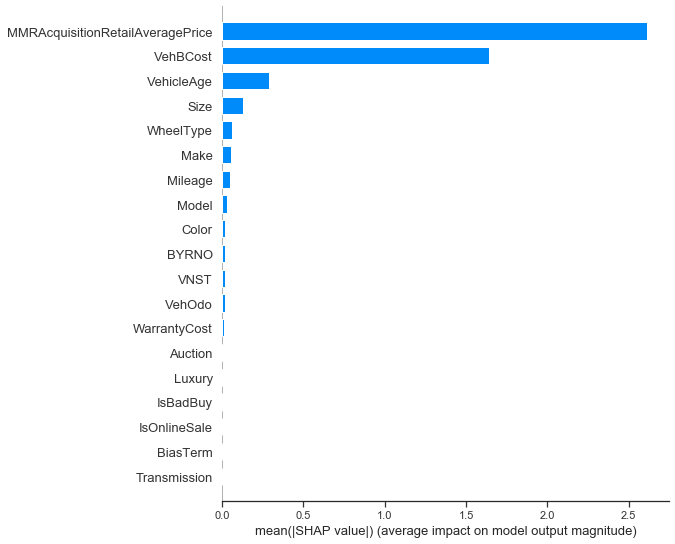

In [20]:
shap.summary_plot(shap_values, names, plot_type="bar")

# DRF - Task2- Regression (Best of AutoML): MMRAcquisitionAuctionAveragePrice (h2o)

In [124]:
h2o_frame = h2o.H2OFrame(kick_data)

#Set variables and columns
y = 'MMRAcquisitionAuctionAveragePrice'
x = h2o_frame.col_names
try:
    x.remove('state') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")

try:
    x.remove('zip') #duplicate column
except:
    print("Columns not found. Drop has already been performed.")
    
try:
    x.remove('SubModel')
except:
    print("Columns not found. Drop has already been performed.")

x.remove(y)
x.remove('PurchDate')
x.remove('VehYear')
x.remove('VNZIP1')
x.remove('WheelTypeID')
x.remove('Nationality')
x.remove('TopThreeAmericanName') 
x.remove('Trim')

print(" ")
print("Response = " + str(y))
print(" ")
print("Predictors = " + str(x))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Columns not found. Drop has already been performed.
Columns not found. Drop has already been performed.
 
Response = MMRAcquisitionAuctionAveragePrice
 
Predictors = ['IsBadBuy', 'Auction', 'VehicleAge', 'Make', 'Model', 'Color', 'Transmission', 'WheelType', 'VehOdo', 'Size', 'MMRAcquisitionRetailAveragePrice', 'BYRNO', 'VNST', 'VehBCost', 'IsOnlineSale', 'WarrantyCost', 'Mileage', 'Luxury', 'Axle', 'Cylinder']


In [146]:
train,test,valid = h2o_frame.split_frame(ratios=[.7, .15])
train[y] = train[y].asnumeric()
test[y] = test[y].asnumeric()
valid[y] = valid[y].asnumeric()

train[continuous_features] = train[continuous_features].scale(center=True, scale=True)

In [147]:
print(y)

MMRAcquisitionAuctionAveragePrice


In [150]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
# ### Distributed Random Forest #Task2
folds = 10
drf_MMRA_A_A_Price_Final = H2ORandomForestEstimator(
    model_id="drf_MMRA_A_A_Price_Final",
    ntrees=50,
    max_depth=20,
    stopping_rounds=5,
    stopping_tolerance=0.01,
    score_each_iteration=True,
    seed=3000000,
    nfolds = folds,
    keep_cross_validation_predictions = True,
    binomial_double_trees = True,
    stopping_metric = "RMSE",
    balance_classes = True)


drf_MMRA_A_A_Price_Final.train(x=x, y=y, training_frame=train, validation_frame = valid)





drf Model Build progress: |███████████████████████████████████████████████| 100%


In [164]:
# retrieve the model performance
perf = drf_MMRA_A_A_Price_Final.model_performance(valid)
perf


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 44069144.298403956
RMSE: 6638.459482319972
MAE: 6160.752678183745
RMSLE: 6.981258491570175
Mean Residual Deviance: 44069144.298403956


In [152]:

drf_MMRA_A_A_Price_Final

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  drf_MMRA_A_A_Price_Final


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,27.0,27.0,12743559.0,20.0,20.0,20.0,18720.0,23337.0,21797.926




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03127421471318526
RMSE: 0.1768451715857271
MAE: 0.1036961758124135
RMSLE: NaN
Mean Residual Deviance: 0.03127421471318526

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 44069144.298403956
RMSE: 6638.459482319972
MAE: 6160.752678183745
RMSLE: 6.981258491570175
Mean Residual Deviance: 44069144.298403956

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.02840854753830859
RMSE: 0.1685483537098734
MAE: 0.09754772912899165
RMSLE: NaN
Mean Residual Deviance: 0.02840854753830859

Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,mae,0.09755398,0.0015424916,0.09669083,0.09844982,0.098708086,0.09759429,0.09455893,0.09950744,0.09575274,0.09895351,0.0971524,0.09817176
1,mean_residual_deviance,0.028410405,0.0022956752,0.027102912,0.029155113,0.0287977,0.028598104,0.025026958,0.029193394,0.025611972,0.028804118,0.028409906,0.033403877
2,mse,0.028410405,0.0022956752,0.027102912,0.029155113,0.0287977,0.028598104,0.025026958,0.029193394,0.025611972,0.028804118,0.028409906,0.033403877
3,r2,0.9716099,0.0017960151,0.97200173,0.97145015,0.97194976,0.9721417,0.97398263,0.9713288,0.9734602,0.9707637,0.97172207,0.96729803
4,residual_deviance,0.028410405,0.0022956752,0.027102912,0.029155113,0.0287977,0.028598104,0.025026958,0.029193394,0.025611972,0.028804118,0.028409906,0.033403877
5,rmse,0.16843216,0.006750613,0.16462962,0.17074868,0.16969885,0.16910973,0.15819912,0.17086074,0.16003741,0.16971776,0.16855238,0.18276727
6,rmsle,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2019-10-26 23:51:35,2 min 57.540 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2019-10-26 23:51:35,2 min 58.167 sec,1.0,0.270572,0.144063,0.073209,6633.013101,6154.548652,4.399686e+07
2,,2019-10-26 23:51:36,2 min 58.758 sec,2.0,0.264686,0.139974,0.070059,6634.726189,6156.745452,4.401959e+07
3,,2019-10-26 23:51:37,2 min 59.384 sec,3.0,0.254151,0.138064,0.064593,6635.862236,6158.048285,4.403467e+07
4,,2019-10-26 23:51:37,3 min 0.010 sec,4.0,0.243727,0.134695,0.059403,6637.067854,6159.318413,4.405067e+07
5,,2019-10-26 23:51:38,3 min 0.621 sec,5.0,0.240526,0.134560,0.057853,6637.701331,6159.976022,4.405908e+07
6,,2019-10-26 23:51:38,3 min 1.167 sec,6.0,0.231698,0.130708,0.053684,6637.924251,6160.188985,4.406204e+07
7,,2019-10-26 23:51:39,3 min 1.793 sec,7.0,0.229153,0.129681,0.052511,6637.982045,6160.230588,4.406281e+07
8,,2019-10-26 23:51:40,3 min 2.432 sec,8.0,0.220322,0.126196,0.048542,6638.236366,6160.487595,4.406618e+07
9,,2019-10-26 23:51:40,3 min 3.061 sec,9.0,0.214914,0.124800,0.046188,6638.004320,6160.293346,4.406310e+07



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,MMRAcquisitionRetailAveragePrice,652542.187500,1.000000,0.615822
1,VehBCost,168088.062500,0.257590,0.158629
2,VehicleAge,79882.546875,0.122417,0.075387
3,Model,37692.558594,0.057763,0.035572
4,Size,37532.640625,0.057518,0.035421
5,Mileage,32981.695312,0.050543,0.031126
6,Make,21896.632812,0.033556,0.020664
7,VNST,7442.123535,0.011405,0.007023
8,WarrantyCost,5825.404785,0.008927,0.005498
9,VehOdo,4625.782715,0.007089,0.004365


In [153]:
## Final Prediction for Model 2
final_drf_predictions = drf_MMRA_A_A_Price_Final.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [154]:
final_drf_predictions.head()

predict
4.87443
2.76311
5.60334
3.80778
4.52257
4.41649
3.54592
3.80827
4.58013
3.97295


In [155]:
# test set accuracy
(final_drf_predictions['predict']==test['MMRAcquisitionAuctionAveragePrice']).as_data_frame(use_pandas=True).mean()

predict    0.0
dtype: float64

In [156]:
drf_MMRA_A_A_Price_Final.model_performance()


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.03127421471318526
RMSE: 0.1768451715857271
MAE: 0.1036961758124135
RMSLE: NaN
Mean Residual Deviance: 0.03127421471318526


In [157]:
drf_MMRA_A_A_Price_Final.r2()

0.968725172549992

In [158]:
drf_MMRA_A_A_Price_Final.rmsle()

'NaN'

In [159]:
drf_MMRA_A_A_Price_Final.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'drf_MMRA_A_A_Price_Final',
   'type': 'Key<Model>',
   'URL': '/3/Models/drf_MMRA_A_A_Price_Final'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'py_88_sid_bc95',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/py_88_sid_bc95'}},
 'validation_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'py_89_sid_bc95',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/py_89_sid_bc95'}},
 'nfolds': {'default': 0, 'actual': 10},
 'keep_cross_validation_models': {'default': True, 'actual': True},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': F

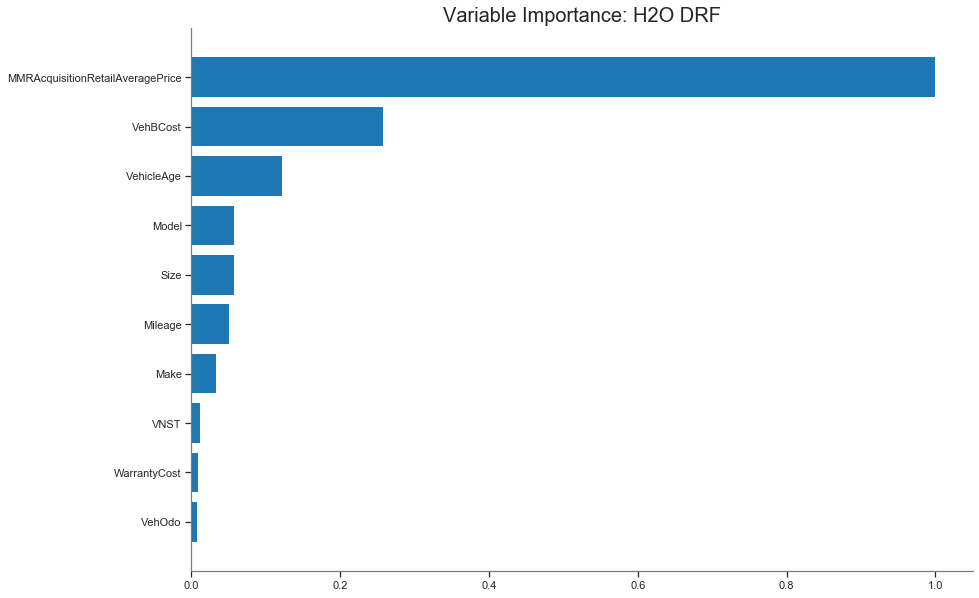

In [160]:
drf_MMRA_A_A_Price_Final.varimp_plot()